In [1]:
import numpy as np
 
import scipy.misc
from scipy.misc import imsave
import time
import os
import h5py
import random
from scipy.ndimage.filters import gaussian_filter, median_filter

from keras.models import Sequential, Model
from keras.layers import Conv2D, Input, MaxPooling2D, Flatten, Dense, Dropout
from keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# path to the model weights file.
weights_path = 'vgg16_weights_tf_dim_ordering_tf_kernels.h5'
 
def VGG_16(w_path=None):
    
    img_input = Input(shape=(3, 224,224))
    
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

        # Classification block
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense(1000, activation='linear', name='predictions')(x) # avoid softmax (see Simonyan 2013)

    model = Model(img_input, x, name='vgg16')
    
    if w_path:
        model.load_weights(w_path)
 
    return model
 
# Creates the VGG models and loads weights
model = VGG_16(weights_path)
print('Model loaded.')
model.summary()

Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 224, 224)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 224, 224)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 224, 224)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 112, 112)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 112, 112)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 112, 112)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 56, 56)       0      

In [ ]:
img_width = 224
img_height = 224

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_name = 'block1_conv1'

# util function to convert a tensor into a valid image


def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)


kept_filters = []
all_filter = [x for x in range(64)]
filter_sample = random.sample(all_filter, 32)

for ix, filter_index in enumerate(filter_sample):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    loss = K.mean(layer_output[:, filter_index, :, :])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    input_img_data = np.random.random((1, 3, img_width, img_height))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    mFilterSize = 5
    mFilterEvery = 10
    mIter = 201
    
    # we run gradient ascent for 20 steps
    for i in range(mIter):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        input_img_data = np.clip(input_img_data, 0., 255.)
                        
        if mFilterSize is not 0 and i % mFilterEvery == 0 :
            input_img_data = median_filter(input_img_data, size=(1, 1, mFilterSize, mFilterSize))
    
        if i % 50 == 0:
            print('\t%d, Current loss value:%f' % (i, loss_value))

    # decode the resulting input image
    img = deprocess_image(input_img_data[0])
    kept_filters.append((img, loss_value))
    end_time = time.time()
    print('%d, Filter %d processed in %ds' % (ix, filter_index, end_time - start_time))
    
print("="*80)
print("Finish!")

Processing filter 18
	0, Current loss value:13.226337
	50, Current loss value:188.804794
	100, Current loss value:364.886108
	150, Current loss value:490.641052
	200, Current loss value:513.403931
0, Filter 18 processed in 3s
Processing filter 60
	0, Current loss value:4.686477
	50, Current loss value:15.409548
	100, Current loss value:17.042671
	150, Current loss value:18.247536
	200, Current loss value:19.197266
1, Filter 60 processed in 3s
Processing filter 51
	0, Current loss value:5.742273
	50, Current loss value:30.936607
	100, Current loss value:39.820000
	150, Current loss value:45.236942
	200, Current loss value:49.552036
2, Filter 51 processed in 3s
Processing filter 5
	0, Current loss value:0.000000
	50, Current loss value:0.000000
	100, Current loss value:0.000000
	150, Current loss value:0.000000
	200, Current loss value:0.000000
3, Filter 5 processed in 2s
Processing filter 3
	0, Current loss value:4.504067
	50, Current loss value:18.970854
	100, Current loss value:19.886

(224, 224, 3)
67


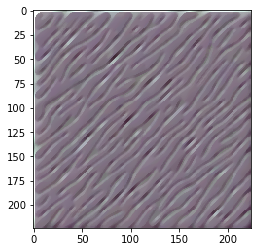

In [119]:
plt.imshow(kept_filters[0][0])
print(kept_filters[0][0].shape)
print(len(kept_filters))

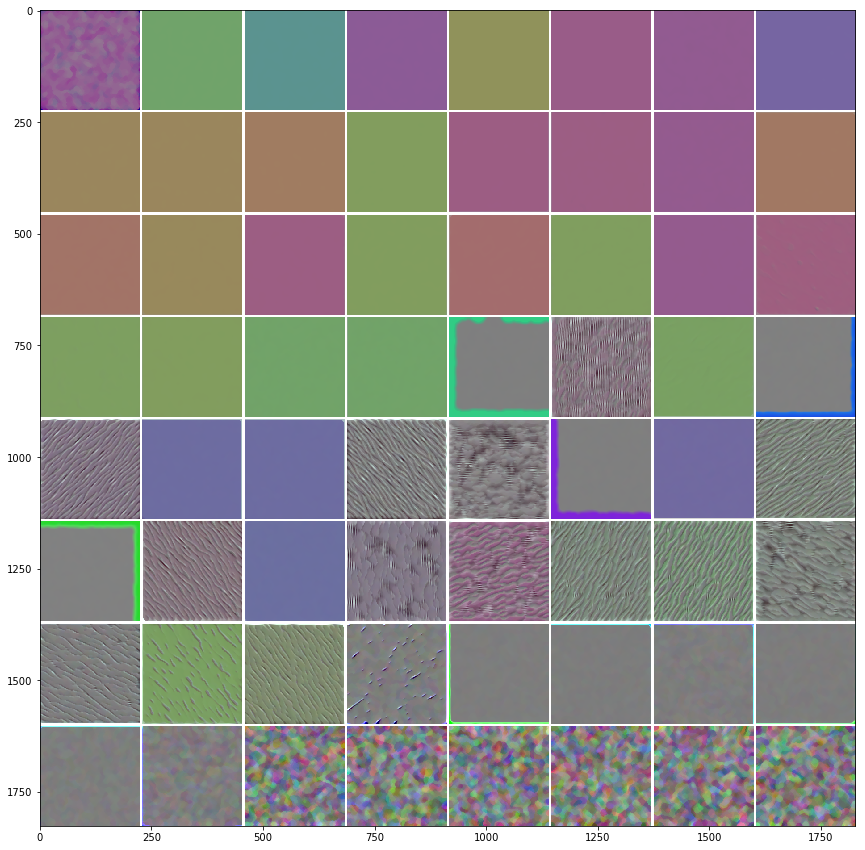

In [120]:
# we will stich the best 64 filters on a 8 x 8 grid.
n = 5

# # the filters that have the highest loss are assumed to be better-looking.
# # we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
new_kept_filters = kept_filters[:n * n]


# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3), dtype=np.uint8)
stitched_filters.fill(255)

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = new_kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

# # save the result to disk
plt.figure(figsize=(15,15))
plt.imshow(stitched_filters)
imsave('%s.lr%d.it%d.%dx%d.png' % (layer_name, step, 200, n, n), stitched_filters)

In [124]:
for i, x in enumerate(new_kept_filters):
    print()
    imsave('conv1_1/%d.png' % (i), x[0])